In [15]:
#%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from src.cpm_basic import CellularPottsModel
from scipy.spatial import ConvexHull
import matplotlib.cm as cm
import pickle
from skimage.measure import regionprops, label, perimeter as measure_perimeter
from scipy.ndimage import label as label_scipy
import pandas as pd

# Time Development 

In [16]:
n_cells=38
n_types=2 
T=26 
L=100
C_p=1
adhessions= np.array([[0, 0.2, 0.2],  
                      [0.2, 10, 20],
                      [0.2, 20, 10]]) 
volume_coefficient= np.array([0, 10, 10])
lattice_type="prerun"
object_volumes=None # Is default set in the CPM class if none
periodic=False

In [17]:
init = ["hex", "prerun", "circle"]
energies = []

for i in init:
    cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient,
                             adhessions=adhessions, lattice_type=i, object_volumes=object_volumes, periodic=periodic)
    energy = cpm.run_time_development_sim(steps=500000, interval=1000)
    energies.append(energy)

100%|██████████| 500000/500000 [03:37<00:00, 2296.01it/s]


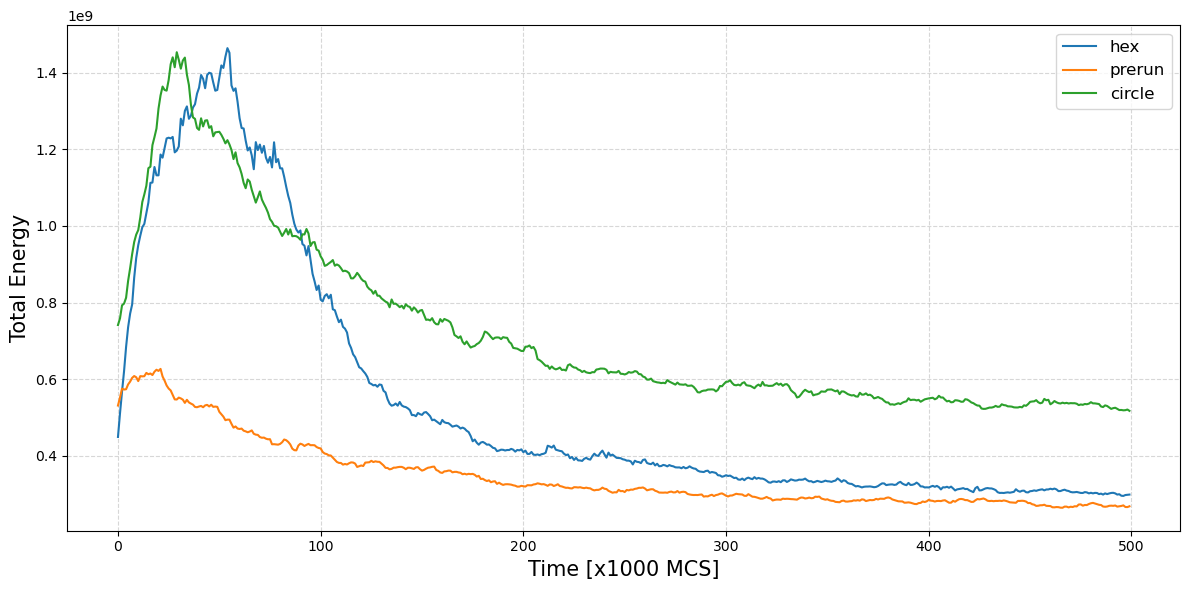

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))


for i, energy in enumerate(energies):
    ax.plot(energy, label=init[i])
ax.set_xlabel("Time [x1000 MCS]", fontsize=15)
ax.set_ylabel("Total Energy", fontsize=15)
ax.legend(fontsize=12)
ax.grid(linestyle='--', alpha=0.5)
fig.tight_layout()
fig.savefig("figures/energy_comparison_overtime.png", dpi=300)
plt.show()

# Varying Area and Perimeter coefficient


$$
\lambda = J*X
$$

$$
\beta = J*X

$$


In [20]:
n_cells=38
n_types=2 
T=26 
L=100
J = 10
adhessions= np.array([[0, 0.2, 0.2],  
                      [0.2, J, J],
                      [0.2, J, J]]) 
volume_coefficient= np.array([0, 10, 10])
C_p=1
lattice_type="hex"
object_volumes=None # Is default set in the CPM class if none
periodic=False

## For Visual Grid 

lambda_values = [0, J, J*5, J*15]  # Area coefficient values
beta_values = [0, J, J*5, J*15]  # Perimeter coefficient values
results = []
types = []
for lambda_v in lambda_values:
    row = []
    row_type = []
    for beta_v in beta_values:
        volume_coefficient= np.array([0, lambda_v, lambda_v])
        C_p=beta_v
        cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient,
                                 adhessions=adhessions, lattice_type=lattice_type, object_volumes=object_volumes, periodic=periodic)
        M = cpm.run_a_sim(steps=220000)
        row.append(M)
        row_type.append(cpm.tau)
    results.append(row)
    types.append(row_type)

with open('saves/grids_hex.pkl', 'wb') as f:
    pickle.dump(results, f)
    
with open('saves/types_hex.pkl', 'wb') as f:
    pickle.dump(types, f)

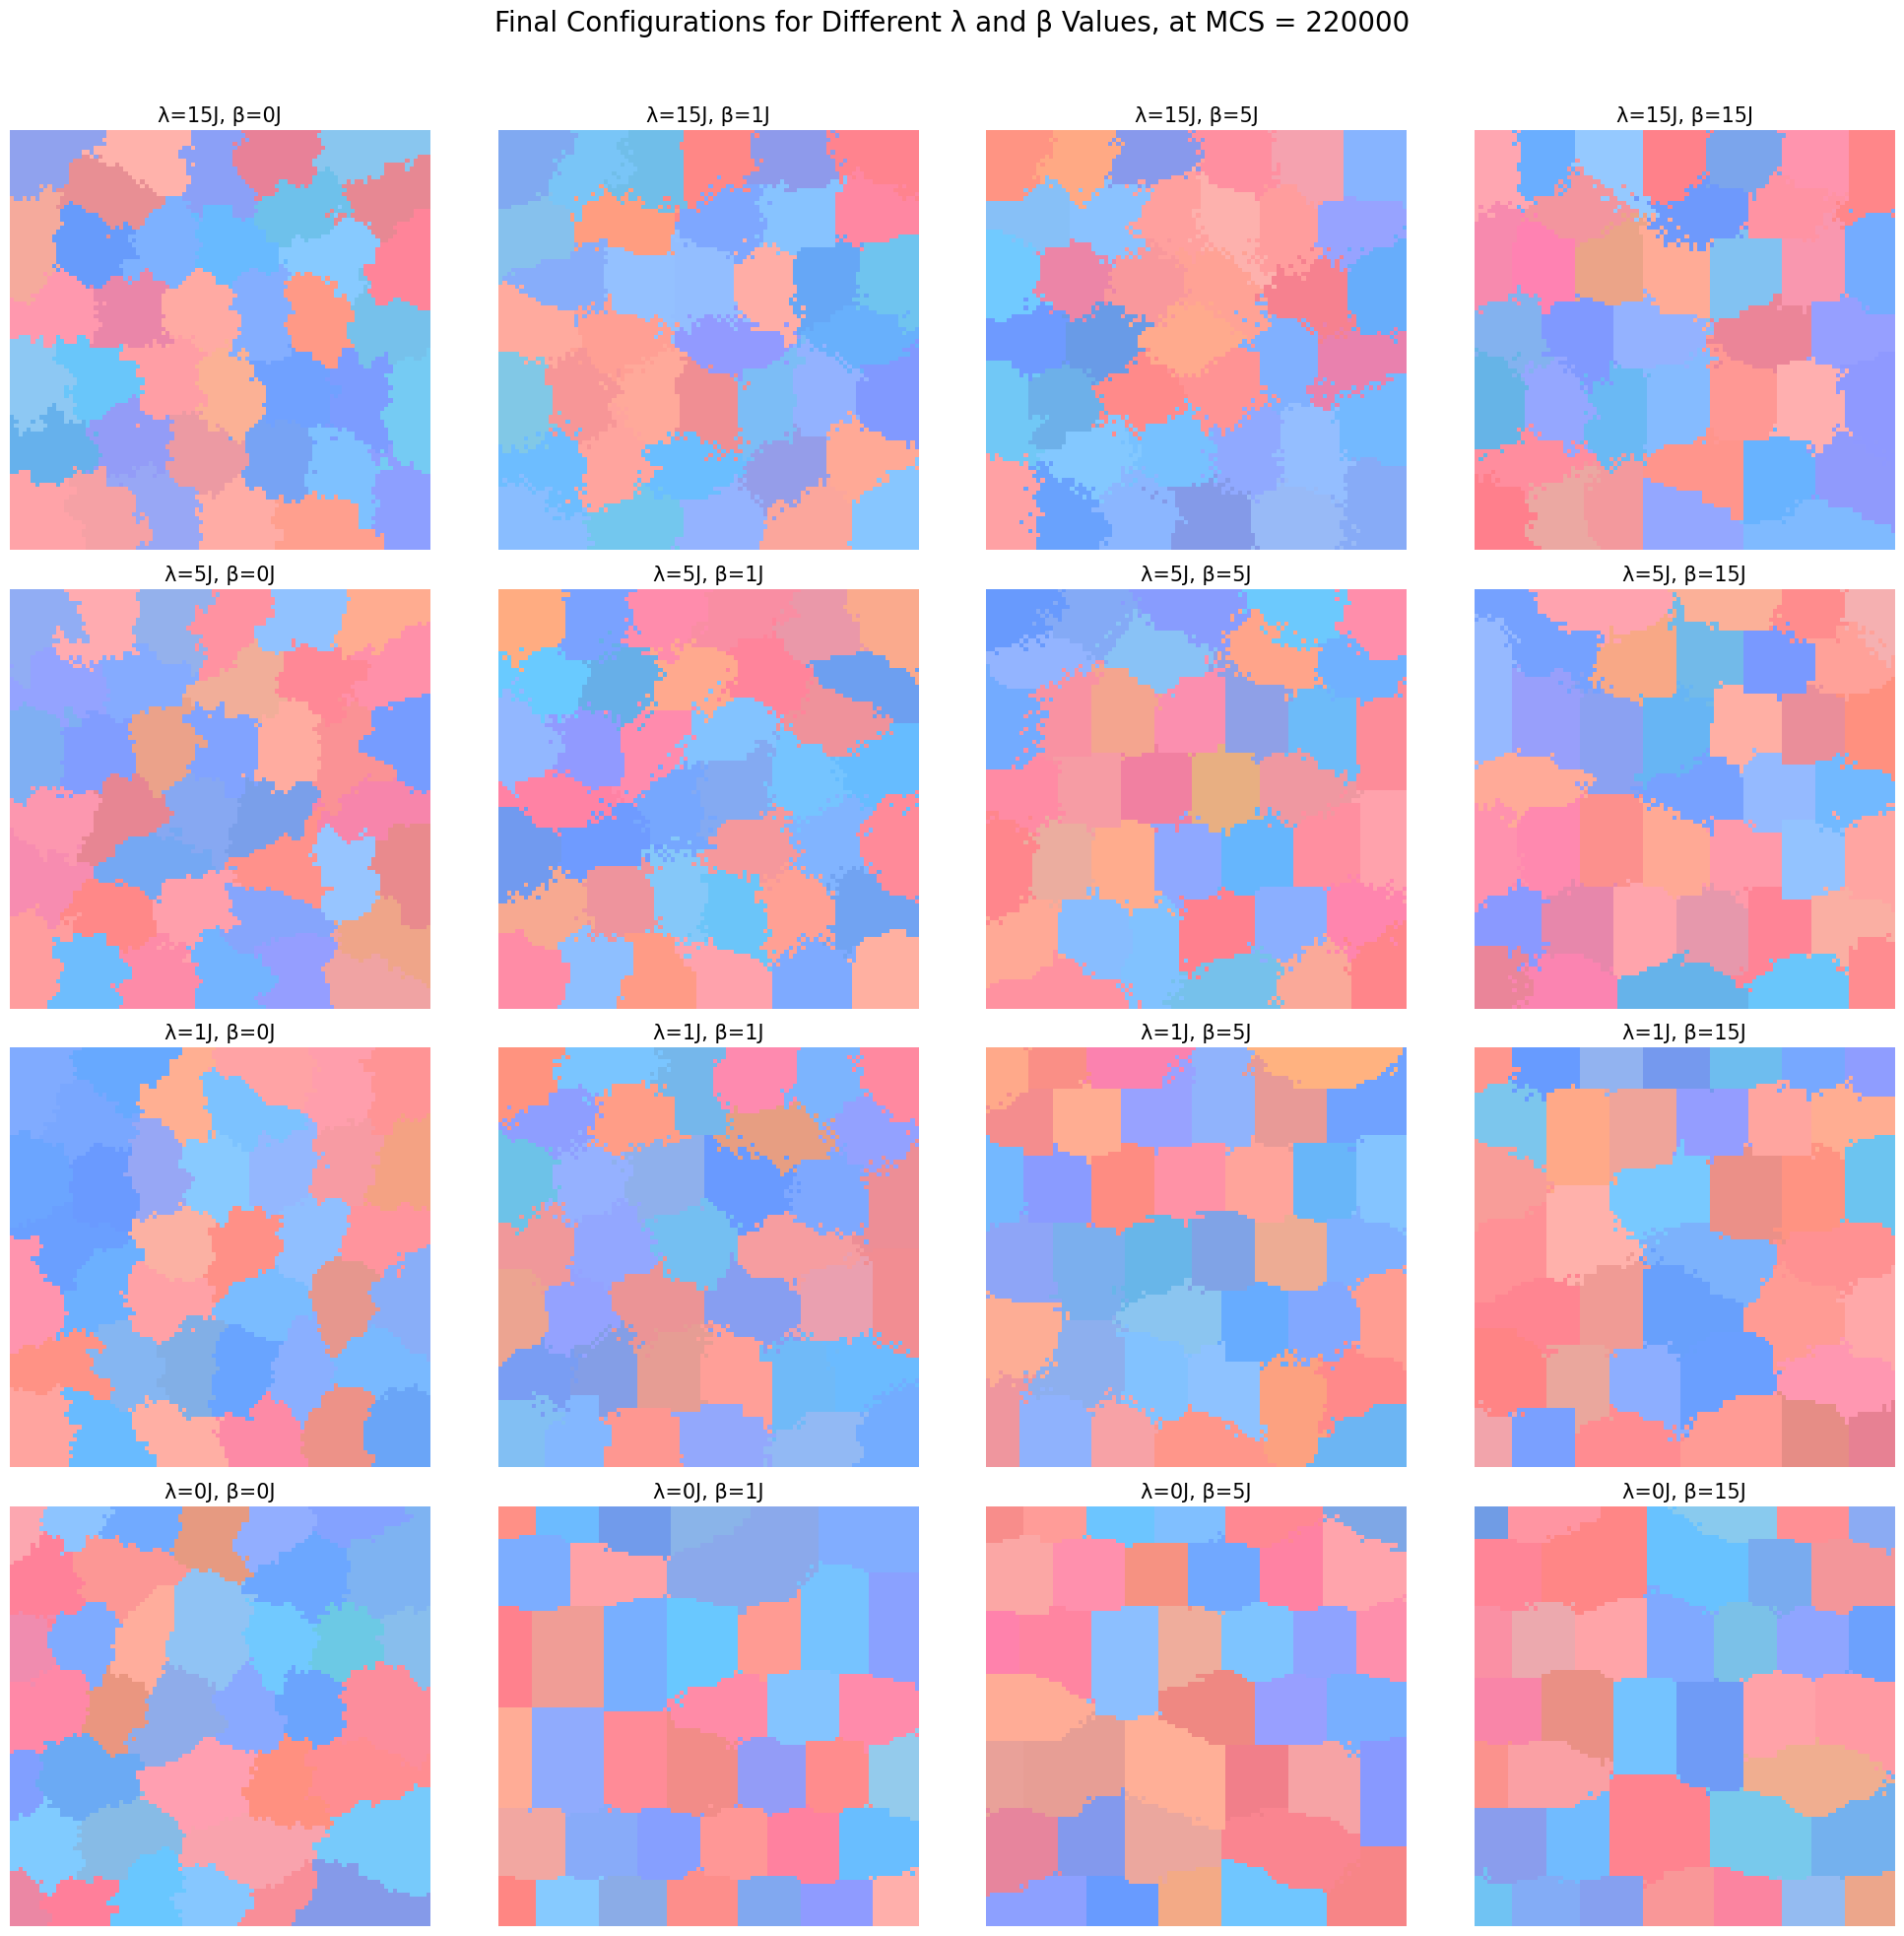

In [13]:
lambda_values = [0, J, J*5, J*15]  # Area coefficient values
beta_values = [0, J, J*5, J*15]  # Perimeter coefficient values

with open('saves/grids_hex.pkl', 'rb') as f:
    grids = pickle.load(f)
with open('saves/types_hex.pkl', 'rb') as f:
    types = pickle.load(f)

def color_code_cells(grid, type_cell):
    """
    Function that color code each cell based on its type with small random variations.
    Only takes two types plus background (0).
    """
    # Define base colors for each type (as RGB)
    type_base_colors = {
        0: np.array([1, 1, 1]),         # white for background
        1: np.array([0.5, 0.7, 1]),     # blue-ish for type 1
        2: np.array([1.0, 0.6, 0.6])      # red-ish for type 2
    }
    unique_cells = np.unique(grid)
    # Build an array of base colors for each unique cell
    base_colors = np.array([type_base_colors[type_cell[cell]] for cell in unique_cells])
    variations = (np.random.rand(len(unique_cells), 3) - 0.5) * 0.2

    # Cells with id 0 get no variation
    zero_mask = (unique_cells == 0)
    variations[zero_mask] = 0.0

    # Final colors for each unique cell
    all_colors = np.clip(base_colors + variations, 0, 1)
    # Map: cell_id → row index in unique_cells array
    cell_to_index = {cell: idx for idx, cell in enumerate(unique_cells)}
    # Build an index array matching A
    index_grid = np.vectorize(cell_to_index.get)(grid)

    # Build final color grid (vectorized gather)
    color_grid = all_colors[index_grid]
    return color_grid



fig, ax = plt.subplots(len(lambda_values), len(beta_values), figsize=(20, 20))

n_lambda = len(lambda_values)
n_beta = len(beta_values)

for i in range(n_lambda):
    for j in range(n_beta):
        row = n_lambda - 1 - i   # invert row index
        col = j
        color_grid = color_code_cells(grids[i][j], types[i][j])

        ax[row, col].imshow(color_grid)
        ax[row, col].set_title(
            f"λ={int(lambda_values[i]/J)}J, β={int(beta_values[j]/J)}J", fontsize=15
        )
        ax[row, col].axis('off')
fig.suptitle("Final Configurations for Different λ and β Values, at MCS = 220000", fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("figures/imshow_of_different_lambda_beta_values.png", dpi=300)
plt.show()

## Quantitative Metric Evaluation

In [10]:
def quantitative_metric_eval(grid): 
    cells_id = np.unique(grid)
    def compactness_calculation(cell_id):
        cell_mask = (grid == cell_id)
        area = np.sum(cell_mask)
        if area == 0:
            return 0
        perimeter = measure_perimeter(cell_mask, neighborhood=8)
        if perimeter == 0:
            return 0
        compactness_value = perimeter   / (2 * np.sqrt(np.pi * area))
        return compactness_value
    
    def quantify_fragmentation(grid_array, value):
        # 1. Isolate the target value
        # Creates a boolean mask where True means the cell has the target value.
        target_mask = (grid_array == value)

        
        # 2. Label the connected components
        # 'label' finds groups of connected True cells. The structure parameter 
        # defines connectivity (default is 8-connectivity, but we use a 4x4 
        # structure here to explicitly enforce 4-connectivity).
        # If you prefer 8-connectivity (touching corners counts), use default 
        # structure or structure=np.ones((3, 3)))
        
        # Use 4-connectivity: only adjacent sides count as connected
        structure = np.array([[0, 1, 0],
                            [1, 1, 1],
                            [0, 1, 0]])

        _, num_patches = label_scipy(target_mask, structure=structure)
        return num_patches
    
    def quantify_sinuosity_skimage(grid_array, value):
        """
        Calculates the Sinuosity Index (P / P_CH) for a specific cell value 
        using skimage.measure.perimeter for geometric accuracy.
        """
        # 1. Isolate the target mask
        target_mask = (grid_array == value)
        area = np.sum(target_mask)
        
        if area == 0:
            return 0, 0, None

        # 2. Calculate Actual Perimeter (P) using skimage
        # skimage.measure.perimeter calculates the boundary length based on 
        # a contour tracing algorithm, providing a floating-point, geometric length.
        actual_perimeter = measure_perimeter(target_mask, neighborhood=8) # connectivity=1 forces 4-connectivity
        
        # 3. Calculate Convex Hull Perimeter (P_CH)
        # Get the coordinates (points) of all cells belonging to the patch
        points_coords = np.argwhere(target_mask)
        
        if len(points_coords) < 3:
            # Cannot compute a convex hull for 1 or 2 points
            return area, actual_perimeter, 1.0
        try:
            hull = ConvexHull(points_coords)
            
            # Calculate the Euclidean length of the hull edges
            hull_points = points_coords[hull.vertices]
            convex_hull_perimeter = 0
            
            for i in range(len(hull_points)):
                p1 = hull_points[i]
                p2 = hull_points[(i + 1) % len(hull_points)]
                
                # Euclidean distance
                distance = np.sqrt(np.sum((p1 - p2)**2))
                convex_hull_perimeter += distance
                
        except Exception as e:
            print(f"Warning: Could not compute Convex Hull for value {value}. Error: {e}")
            return area, actual_perimeter, None

        # 4. Calculate Sinuosity Index
        if convex_hull_perimeter == 0:
            sinuosity_index = 1.0
        else:
            # Sinuosity Index = Geometric Perimeter / Convex Hull Perimeter
            sinuosity_index = actual_perimeter / convex_hull_perimeter
            
        return sinuosity_index

    compactness_values = [compactness_calculation(cell_id) for cell_id in cells_id if cell_id != 0]
    compactness = np.mean(compactness_values)

    fragmentation_values = [quantify_fragmentation(grid, cell_id) for cell_id in cells_id if cell_id != 0]
    fragmentation = np.mean(fragmentation_values)

    sinuosity_values = [quantify_sinuosity_skimage(grid, cell_id) for cell_id in cells_id if cell_id != 0]
    sinuosity = np.mean([val for val in sinuosity_values if val is not None])


    return compactness, fragmentation, sinuosity  # compactness, fragmentation, and sinuosity metrics averaged over all cells

In [11]:
compactness_results = np.zeros((n_lambda, n_beta))
fragmentation_results = np.zeros((n_lambda, n_beta))
sinuosity_results = np.zeros((n_lambda, n_beta))

for i in range(n_lambda):
    for j in range(n_beta):
        compactness, fragmentation, sinuosity = quantitative_metric_eval(grids[i][j])
        compactness_results[i, j] = compactness
        fragmentation_results[i, j] = fragmentation
        sinuosity_results[i, j] = sinuosity

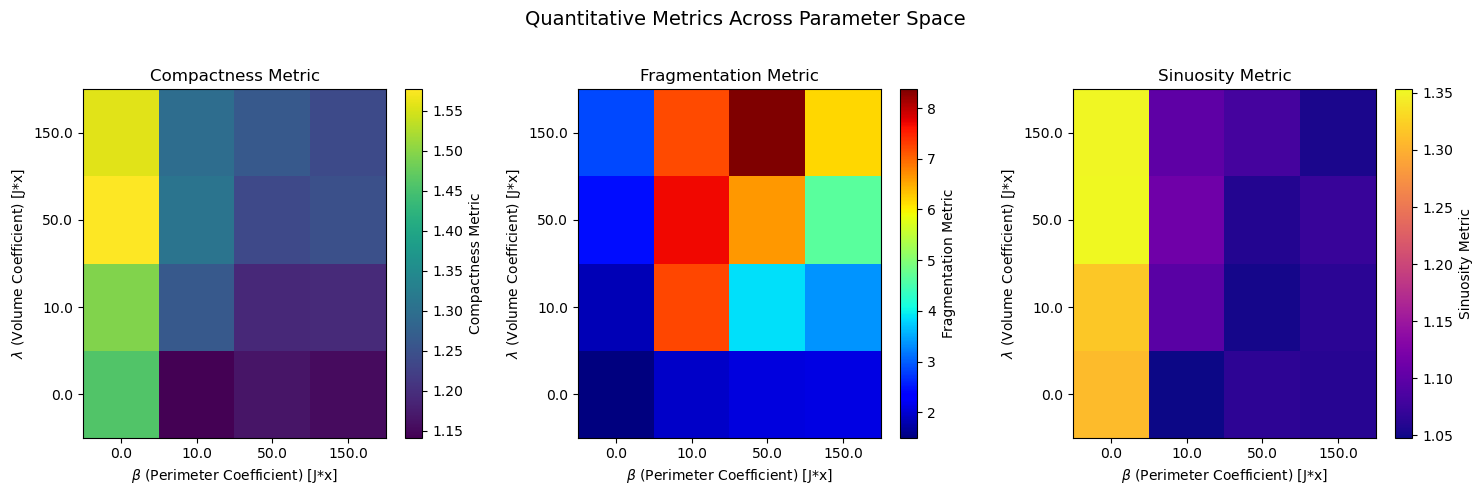

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_extent = [0, n_beta, 0, n_lambda]
# --- Plot 1: Compactness ---
im0 = ax[0].imshow(compactness_results, cmap='viridis', extent=plot_extent, origin='lower', aspect='auto')

plt.colorbar(im0, ax=ax[0], label='Compactness Metric')

# Set ticks to the index locations (0, 1, 2, 3)
ax[0].set_xticks(np.arange(n_beta) + 0.5) # +0.5 centers the tick on the pixel
ax[0].set_yticks(np.arange(n_lambda) + 0.5)

# Set labels using the actual coefficient values
ax[0].set_xticklabels([f'{val:.1f}' for val in beta_values])
ax[0].set_yticklabels([f'{val:.1f}' for val in lambda_values])

ax[0].set_xlabel(r'$\beta$ (Perimeter Coefficient) [J*x]')
ax[0].set_ylabel(r'$\lambda$ (Volume Coefficient) [J*x]')
ax[0].set_title('Compactness Metric')

# --- Plot 2: Fragmentation ---
im1 = ax[1].imshow(fragmentation_results, cmap='jet', extent=plot_extent, origin='lower', aspect='auto')

plt.colorbar(im1, ax=ax[1], label='Fragmentation Metric')

# Set ticks and labels for the second plot
ax[1].set_xticks(np.arange(n_beta) + 0.5)
ax[1].set_yticks(np.arange(n_lambda) + 0.5)
ax[1].set_xticklabels([f'{val:.1f}' for val in beta_values])
ax[1].set_yticklabels([f'{val:.1f}' for val in lambda_values])

ax[1].set_xlabel(r'$\beta$ (Perimeter Coefficient) [J*x]')
ax[1].set_ylabel(r'$\lambda$ (Volume Coefficient) [J*x]')
ax[1].set_title('Fragmentation Metric')

# --- Plot 3: Sinuosity ---
im2 = ax[2].imshow(sinuosity_results, cmap='plasma', extent=plot_extent, origin='lower', aspect='auto')
plt.colorbar(im2, ax=ax[2], label='Sinuosity Metric')
# Set ticks and labels for the third plot
ax[2].set_xticks(np.arange(n_beta) + 0.5)
ax[2].set_yticks(np.arange(n_lambda) + 0.5)
ax[2].set_xticklabels([f'{val:.1f}' for val in beta_values])
ax[2].set_yticklabels([f'{val:.1f}' for val in lambda_values])
ax[2].set_xlabel(r'$\beta$ (Perimeter Coefficient) [J*x]')
ax[2].set_ylabel(r'$\lambda$ (Volume Coefficient) [J*x]')
ax[2].set_title('Sinuosity Metric')


# --- Final Adjustments ---
plt.suptitle('Quantitative Metrics Across Parameter Space', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig("figures/quantitative_metrics_across_parameter_space.png", dpi=300)
plt.show()

### Quantitative Multiple

In [19]:
lambda_values_mul = np.linspace(0, J*100, 30) # Area coefficient values 
beta_values_mul = np.linspace(0, J*100, 30) # Perimeter coefficient values 
res_multiple = [] 
types_multiple = [] 

for lambda_v in lambda_values_mul:
    row = [] 
    row_type = [] 
    for beta_v in beta_values_mul: 
        volume_coefficient= np.array([0, lambda_v, lambda_v]) 
        C_p=beta_v 
        cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient, 
                                 adhessions=adhessions, lattice_type=lattice_type, object_volumes=object_volumes, periodic=periodic) 
        M = cpm.run_a_sim(steps=220000) 
        row.append(M) 
        row_type.append(cpm.tau) 
    res_multiple.append(row) 
    types_multiple.append(row_type)

with open('saves/grids_hex_multiple.pkl', 'wb') as f:
    pickle.dump(res_multiple, f)
with open('saves/types_hex_multiple.pkl', 'wb') as f:
    pickle.dump(types_multiple, f)

100%|██████████| 220000/220000 [00:24<00:00, 8868.29it/s]
